# Ship\Iceberg Discrimation

In [3]:
# common imports
import random
import numpy as np
import pandas as pd
from visualizations import plot_cnn_model, plot_history, plot_confusion_matrix, show_bands
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


## Data Exploration

### Load Data


In [4]:
train_data = pd.read_json('train/data/processed/train.json') 
test_data = pd.read_json('test/data/processed/test.json')

In [5]:
train_data.head()

,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0
1,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0


In [6]:
train_data = train_data[train_data['inc_angle']!='na'] # drop rows with na values

## Auxiliary code

### Prepare test dataset for evaluation on Kaggle platform

In [11]:
import pandas as pd

def write_submission_file(ids, predictions, name, valid_loss):
    submission = pd.DataFrame({'id': ids, 'is_iceberg': predictions})
    submission.to_csv('out/submission_' + name + '_' + str(valid_loss) + '.csv', index=False)

## Models

### Convolutional Neural Network (CNN)

#### Data preparation

In [7]:
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)
from skimage.filters import gaussian


def make_3d_images(df, filt = False, sigma = 0.2):
    imgs = []
    
    for i, row in df.iterrows():
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
        band_3 = (band_1 + band_2)/2 
        
        # Rescale
        im1 = (band_1 - band_1.mean()) / (band_1.max() - band_1.min())
        im2 = (band_2 - band_2.mean()) / (band_2.max() - band_2.min())
        im3 = np.ndarray((75, 75))
        im3.fill(0 if row['inc_angle'] == 'na' else float(row['inc_angle']))
        im3 = im3 * 1./60.
        
        if (filt):
            im1 = denoise_wavelet(im1, convert2ycbcr=True)
            im2 = denoise_wavelet(im2,convert2ycbcr=True)
            
            im1 = gaussian(im1, sigma)
            im2 = gaussian(im2, sigma)
        
        imgs.append(np.dstack((im1, im2, im3)))

    return np.array(imgs)

train_images_filt = make_3d_images(train_data, True)
train_images = make_3d_images(train_data, False)
train_labels = train_data['is_iceberg'].as_matrix()
train_angles = train_data['inc_angle'].as_matrix()

test_images_filt = make_3d_images(test_data, True)
test_images = make_3d_images(test_data, False)
test_angles = test_data['inc_angle'].as_matrix()

X_train_filt, X_valid_filt, X_train, X_valid, ang_train, ang_valid, y_train_lab, y_valid_lab = train_test_split(train_images_filt, train_images, train_angles, train_labels, test_size = 0.25, random_state = 42)

print("Shape of train dataset:", train_images.shape)
print("Shape of test dataset:", test_images.shape)

Shape of train dataset: (1471, 75, 75, 3)
Shape of test dataset: (8424, 75, 75, 3)


In [8]:
train_images_1 = make_3d_images(train_data, True)
train_images_2 = make_3d_images(train_data, False)
train_images_3 = make_3d_images(train_data, True, 0.4)

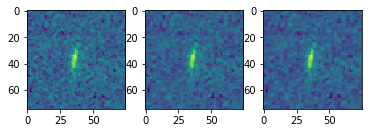

In [9]:
# transformed images vs untransformed
import matplotlib.pyplot as plt

ax = plt.subplot(131)
ax.imshow(train_images_2[10][:,:,0])

ax = plt.subplot(132)
ax.imshow(train_images_1[10][:,:,0])

ax = plt.subplot(133)
ax.imshow(train_images_3[10][:,:,0])

plt.show()

In [10]:
train_images_extra = np.concatenate((train_images_1, train_images_2, train_images_3))
train_labels_extra = np.concatenate((train_labels, train_labels, train_labels))

print("Shape of train dataset:", train_images_extra.shape)
print("Shape of test dataset:", train_labels_extra.shape)

Shape of train dataset: (4413, 75, 75, 3)
Shape of test dataset: (4413,)


In [11]:
X_train_extra, X_valid_extra, y_train_extra, y_valid_extra = train_test_split(train_images_extra, train_labels_extra, test_size = 0.25, random_state = 42)

#### Build naive model

In [78]:
from keras.layers import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.models import Sequential

def naive_model(no_summary=False):
    model = Sequential()

    model.add(Conv2D(64, (3, 3), input_shape=(75, 75, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Dropout(0.1))

    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Dropout(0.1))

    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dropout(0.7))
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.7))
    model.add(Dense(100))
    model.add(Activation('relu'))
    model.add(Dropout(0.7))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    
    if not no_summary:
        model.summary()
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = naive_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 73, 73, 64)        1792      
_________________________________________________________________
activation_31 (Activation)   (None, 73, 73, 64)        0         
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
activation_32 (Activation)   (None, 34, 34, 128)       0         
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 17, 17, 128)       0         
__________

In [79]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

train_datagen = ImageDataGenerator(
        rotation_range=360,
        width_shift_range=0.6,
        height_shift_range=0.6,
        shear_range=0.1,
        zoom_range=0.4,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='wrap')

epochs = 200
batch_size = 50

valid_datagen = ImageDataGenerator()

earlyStopping = EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, epsilon=1e-4, mode='min')
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.naive_model.hdf5', 
                               verbose=1, save_best_only=True)

history = model.fit_generator(train_datagen.flow(X_train, y_train_lab, batch_size=batch_size),
                    steps_per_epoch = X_train.shape[0] // batch_size,
                    epochs=epochs, verbose=1, callbacks=[checkpointer, earlyStopping, reduce_lr_loss],
                    validation_data = valid_datagen.flow(X_valid, y_valid_lab, batch_size=batch_size),
                    validation_steps=X_valid.shape[0] // batch_size)

Epoch 1/200
22/22 [==============================] - 25s - loss: 0.7058 - acc: 0.5036 - val_loss: 0.6929 - val_acc: 0.5200
Epoch 2/200
22/22 [==============================] - 21s - loss: 0.6955 - acc: 0.4955 - val_loss: 0.6932 - val_acc: 0.4969
Epoch 3/200
22/22 [==============================] - 20s - loss: 0.6940 - acc: 0.5073 - val_loss: 0.6916 - val_acc: 0.5409
Epoch 4/200
22/22 [==============================] - 23s - loss: 0.6949 - acc: 0.5292 - val_loss: 0.6925 - val_acc: 0.5440
Epoch 5/200
22/22 [==============================] - 21s - loss: 0.6955 - acc: 0.5055 - val_loss: 0.6931 - val_acc: 0.4748
Epoch 6/200
22/22 [==============================] - 21s - loss: 0.6963 - acc: 0.4746 - val_loss: 0.6930 - val_acc: 0.5031
Epoch 7/200
22/22 [==============================] - 23s - loss: 0.6928 - acc: 0.5382 - val_loss: 0.6922 - val_acc: 0.5063
Epoch 8/200
22/22 [==============================] - 21s - loss: 0.6950 - acc: 0.4746 - val_loss: 0.6900 - val_acc: 0.5000
Epoch 9/200
22/2

22/22 [==============================] - 18s - loss: 0.4863 - acc: 0.7586 - val_loss: 0.3552 - val_acc: 0.8239
Epoch 61/200
22/22 [==============================] - 20s - loss: 0.5250 - acc: 0.7532 - val_loss: 0.3586 - val_acc: 0.8365
Epoch 62/200
22/22 [==============================] - 19s - loss: 0.5059 - acc: 0.7714 - val_loss: 0.3711 - val_acc: 0.8396
Epoch 63/200
22/22 [==============================] - 19s - loss: 0.4956 - acc: 0.7550 - val_loss: 0.3538 - val_acc: 0.8208
Epoch 64/200
22/22 [==============================] - 20s - loss: 0.5231 - acc: 0.7887 - val_loss: 0.3747 - val_acc: 0.8270
Epoch 65/200
22/22 [==============================] - 19s - loss: 0.4807 - acc: 0.7932 - val_loss: 0.3349 - val_acc: 0.8371
Epoch 66/200
22/22 [==============================] - 19s - loss: 0.4899 - acc: 0.7614 - val_loss: 0.5744 - val_acc: 0.7358
Epoch 67/200
22/22 [==============================] - 19s - loss: 0.5091 - acc: 0.7768 - val_loss: 0.3485 - val_acc: 0.8428
Epoch 68/200
22/22 [=

22/22 [==============================] - 19s - loss: 0.4253 - acc: 0.7978 - val_loss: 0.2954 - val_acc: 0.8585
Epoch 92/200
22/22 [==============================] - 19s - loss: 0.3757 - acc: 0.8233 - val_loss: 0.2885 - val_acc: 0.8711
Epoch 93/200
22/22 [==============================] - 18s - loss: 0.4058 - acc: 0.8109 - val_loss: 0.2783 - val_acc: 0.9088
Epoch 94/200
21/22 [===========================>..] - ETA: 0s - loss: 0.4134 - acc: 0.8127Epoch 00093: val_loss did not improve

Epoch 00093: reducing learning rate to 1.0000000474974514e-05.
22/22 [==============================] - 18s - loss: 0.4058 - acc: 0.8151 - val_loss: 0.2818 - val_acc: 0.8836
Epoch 95/200
22/22 [==============================] - 19s - loss: 0.4296 - acc: 0.8006 - val_loss: 0.3193 - val_acc: 0.8428
Epoch 96/200
22/22 [==============================] - 19s - loss: 0.3860 - acc: 0.8351 - val_loss: 0.2749 - val_acc: 0.8711
Epoch 97/200
22/22 [==============================] - 19s - loss: 0.4001 - acc: 0.7942 - v

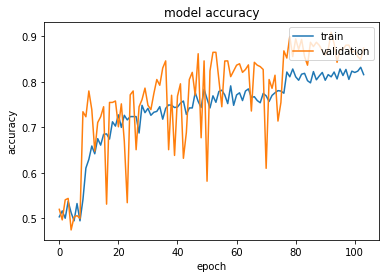

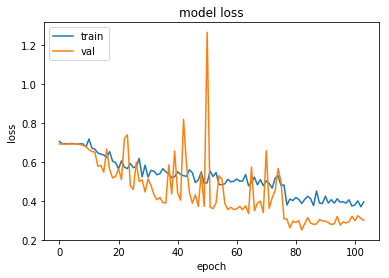

368/368 [==============================] - 1s     


In [81]:
# load best model
model.load_weights('saved_models/weights.best.from_scratch.naive_model.hdf5')

# plot learning curves
plot_history(history)

#evaluate validation dataset
evl = model.evaluate(X_valid, y_valid_lab)
# make test predictions
predictions = model.predict(test_images)

# create file for submission
write_submission_file(test_data['id'], predictions.reshape((predictions.shape[0])), 'naive_model', evl[0])

In [82]:
pred_val = model.predict(train_images)
pred_val = pred_val.reshape((pred_val.shape[0]))

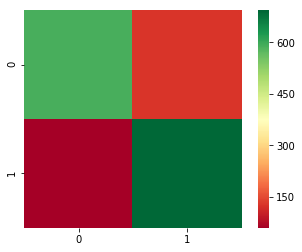

In [83]:
plot_confusion_matrix(train_labels, pred_val > 0.5)

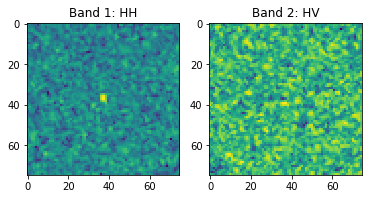

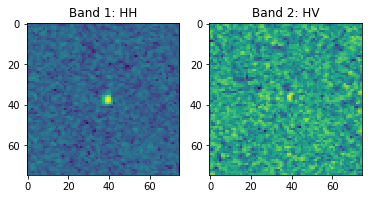

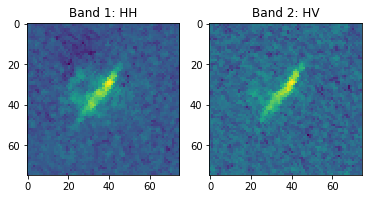

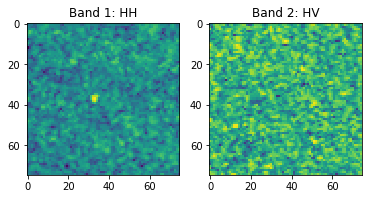

In [84]:
predicted_ships = train_data[pred_val <= 0.5]
misclassified_icebergs = predicted_ships[predicted_ships['is_iceberg'] == 1]
show_bands(misclassified_icebergs.iloc[19])
show_bands(misclassified_icebergs.iloc[20])
show_bands(misclassified_icebergs.iloc[21])
show_bands(misclassified_icebergs.iloc[25])

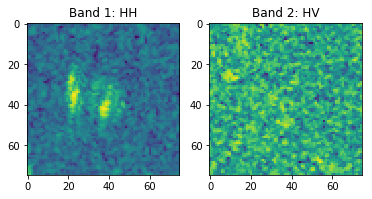

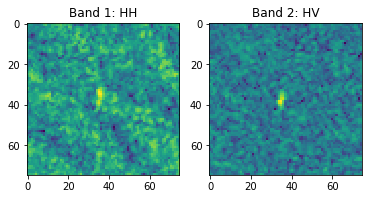

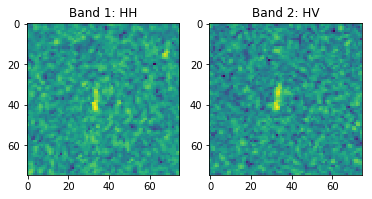

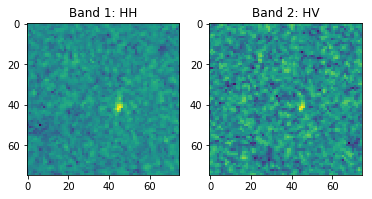

In [85]:
predicted_icebergs = train_data[pred_val > 0.5]
misclassified_ships = predicted_icebergs[predicted_icebergs['is_iceberg'] == 0]
show_bands(misclassified_ships.iloc[4])
show_bands(misclassified_ships.iloc[5])
show_bands(misclassified_ships.iloc[6])
show_bands(misclassified_ships.iloc[7])

*** Achieved test loss (on Kaggle platform): *** 0.2995

#### Build model with auxiliary input

In [104]:
def make_2d_images(df):
    imgs = []
    
    for i, row in df.iterrows():
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
        
        # Rescale
        im1 = (band_1 - band_1.mean()) / (band_1.max() - band_1.min())
        im2 = (band_2 - band_2.mean()) / (band_2.max() - band_2.min())
        imgs.append(np.dstack((im1, im2)))

    return np.array(imgs)

train_images_2d = make_2d_images(train_data)
train_labels_2d = train_data['is_iceberg'].as_matrix()
train_angles_2d = train_data['inc_angle'].as_matrix()
test_images_2d = make_2d_images(test_data)
test_angles_2d = test_data['inc_angle'].as_matrix()

X_train_2d, X_valid_2d, ang_train_2d, ang_valid_2d, y_train_lab_2d, y_valid_lab_2d = train_test_split(train_images_2d, train_angles_2d, train_labels_2d, test_size = 0.25, random_state = 42)

y_train_ang_lab = np.array([ np.array([a, y]) for (a, y) in zip(ang_train_2d, y_train_lab_2d)])
y_valid_ang_lab = np.array([ np.array([a, y]) for (a, y) in zip(ang_valid_2d, y_valid_lab_2d)])

In [109]:
## Another model (with additional input)
from keras.layers import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.layers import Input, Dense
from keras.models import Model
import keras

def model_with_aux(with_summary = True):
    inputs = Input(shape=(75, 75, 2), name='image_input')
    x = Conv2D(64, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.1)(x)

    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.1)(x)

    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Flatten()(x)
    x = Dropout(0.7)(x)

    auxiliary_input = Input(shape=(1,), name='angle_input')
    x = keras.layers.concatenate([x, auxiliary_input])

    x = Dense(256, activation='relu')(x)
    x = Dropout(0.7)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.7)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[inputs, auxiliary_input], outputs=predictions)
    
    if with_summary:
        model.summary()
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = model_with_aux()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
image_input (InputLayer)         (None, 75, 75, 2)     0                                            
____________________________________________________________________________________________________
conv2d_31 (Conv2D)               (None, 73, 73, 64)    1216        image_input[0][0]                
____________________________________________________________________________________________________
max_pooling2d_31 (MaxPooling2D)  (None, 36, 36, 64)    0           conv2d_31[0][0]                  
____________________________________________________________________________________________________
dropout_59 (Dropout)             (None, 36, 36, 64)    0           max_pooling2d_31[0][0]           
___________________________________________________________________________________________

In [110]:
from keras.preprocessing.image import ImageDataGenerator

def generate_data_generator_for_two_sources(datagen, images, y, batch_size):
    flow = datagen.flow(images, y, seed=7, batch_size=batch_size)

    while True:
            f = flow.next()
            yield [f[0], f[1][:, 0]], f[1][:, 1]

In [111]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

epochs = 200
batch_size = 50

train_datagen = ImageDataGenerator(
        rotation_range=360,
        width_shift_range=0.6,
        height_shift_range=0.6,
        shear_range=0.1,
        zoom_range=0.4,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='wrap')

valid_datagen = ImageDataGenerator()


earlyStopping = EarlyStopping(monitor='val_loss', patience=30, verbose=0, mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=15, verbose=1, epsilon=1e-4, mode='min')
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.with_aux_input.hdf5', 
                               verbose=1, save_best_only=True)

history = model.fit_generator(generate_data_generator_for_two_sources(train_datagen, X_train_2d, y_train_ang_lab, batch_size=batch_size),
                    steps_per_epoch=X_train_2d.shape[0] // batch_size,
                    epochs=epochs, verbose=1, callbacks=[checkpointer, earlyStopping, reduce_lr_loss],
                    validation_data=generate_data_generator_for_two_sources(valid_datagen, X_valid_2d, y_valid_ang_lab, batch_size=batch_size),
                    validation_steps=X_valid_2d.shape[0] // batch_size)

Epoch 1/200


/usr/local/lib/python3.5/dist-packages/keras/preprocessing/image.py:787: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (1103, 75, 75, 2) (2 channels).
  ' (' + str(self.x.shape[channels_axis]) + ' channels).')


21/22 [===========================>..] - ETA: 0s - loss: 0.8366 - acc: 0.5019

/usr/local/lib/python3.5/dist-packages/keras/preprocessing/image.py:787: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (368, 75, 75, 2) (2 channels).
  ' (' + str(self.x.shape[channels_axis]) + ' channels).')


Epoch 00000: val_loss improved from inf to 0.69091, saving model to saved_models/weights.best.from_scratch.with_aux_input.hdf5
22/22 [==============================] - 16s - loss: 0.8315 - acc: 0.5027 - val_loss: 0.6909 - val_acc: 0.5000
Epoch 2/200
22/22 [==============================] - 25s - loss: 0.7303 - acc: 0.5210 - val_loss: 0.6836 - val_acc: 0.4843
Epoch 3/200
22/22 [==============================] - 18s - loss: 0.7056 - acc: 0.5418 - val_loss: 0.6383 - val_acc: 0.6195
Epoch 4/200
22/22 [==============================] - 19s - loss: 0.6583 - acc: 0.5938 - val_loss: 0.6222 - val_acc: 0.6321
Epoch 5/200
22/22 [==============================] - 19s - loss: 0.6684 - acc: 0.5884 - val_loss: 0.5923 - val_acc: 0.6635
Epoch 6/200
22/22 [==============================] - 20s - loss: 0.5968 - acc: 0.6821 - val_loss: 0.6225 - val_acc: 0.6478
Epoch 7/200
22/22 [==============================] - 18s - loss: 0.6137 - acc: 0.6803 - val_loss: 0.5135 - val_acc: 0.7704
Epoch 8/200
22/22 [=====

22/22 [==============================] - 18s - loss: 0.5172 - acc: 0.7423 - val_loss: 0.4409 - val_acc: 0.7956
Epoch 32/200
22/22 [==============================] - 20s - loss: 0.5750 - acc: 0.7259 - val_loss: 0.4704 - val_acc: 0.7484
Epoch 33/200
22/22 [==============================] - 19s - loss: 0.4957 - acc: 0.7686 - val_loss: 0.4380 - val_acc: 0.7914
Epoch 34/200
22/22 [==============================] - 20s - loss: 0.5519 - acc: 0.7304 - val_loss: 0.6047 - val_acc: 0.6541
Epoch 35/200
22/22 [==============================] - 19s - loss: 0.5423 - acc: 0.7305 - val_loss: 0.4324 - val_acc: 0.7736
Epoch 36/200
22/22 [==============================] - 19s - loss: 0.5168 - acc: 0.7441 - val_loss: 0.6136 - val_acc: 0.7925
Epoch 37/200
22/22 [==============================] - 20s - loss: 0.6445 - acc: 0.6995 - val_loss: 0.5122 - val_acc: 0.7987
Epoch 38/200
22/22 [==============================] - 19s - loss: 0.4938 - acc: 0.7768 - val_loss: 0.4317 - val_acc: 0.7956
Epoch 39/200
22/22 [=


Epoch 00062: reducing learning rate to 0.00010000000474974513.
22/22 [==============================] - 19s - loss: 0.5538 - acc: 0.7514 - val_loss: 0.4101 - val_acc: 0.8019
Epoch 64/200
22/22 [==============================] - 19s - loss: 0.4776 - acc: 0.7587 - val_loss: 0.3760 - val_acc: 0.8145
Epoch 65/200
22/22 [==============================] - 19s - loss: 0.4403 - acc: 0.7723 - val_loss: 0.3688 - val_acc: 0.8229
Epoch 66/200
22/22 [==============================] - 18s - loss: 0.4438 - acc: 0.7932 - val_loss: 0.3613 - val_acc: 0.8239
Epoch 67/200
22/22 [==============================] - 19s - loss: 0.4253 - acc: 0.8014 - val_loss: 0.3176 - val_acc: 0.8428
Epoch 68/200
22/22 [==============================] - 20s - loss: 0.4034 - acc: 0.7896 - val_loss: 0.4067 - val_acc: 0.8145
Epoch 69/200
22/22 [==============================] - 19s - loss: 0.4414 - acc: 0.7787 - val_loss: 0.3084 - val_acc: 0.8679
Epoch 70/200
22/22 [==============================] - 19s - loss: 0.4199 - acc: 0

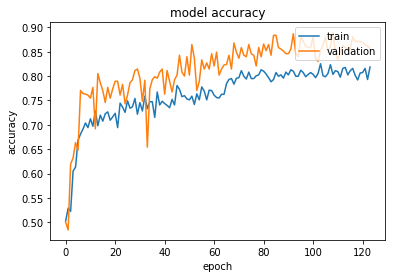

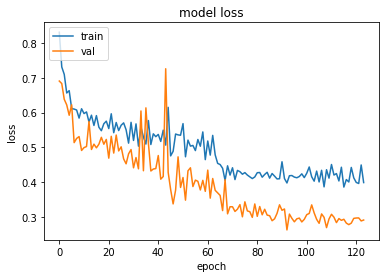

In [112]:
# load best model
model.load_weights('saved_models/weights.best.from_scratch.with_aux_input.hdf5')

# plot learning curves
plot_history(history)

# make test predictions
predictions = model.predict([test_images_2d, test_angles_2d])

# create file for submission
write_submission_file(test_data['id'], predictions.reshape((predictions.shape[0])), 'with_aux_input', 0)

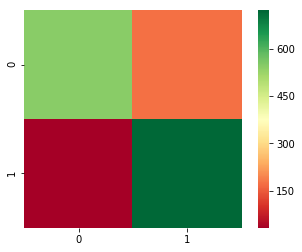

In [114]:
pred_val = model.predict([train_images_2d, train_angles_2d])
pred_val = pred_val.reshape((pred_val.shape[0]))
plot_confusion_matrix(train_labels_2d, pred_val > 0.5)

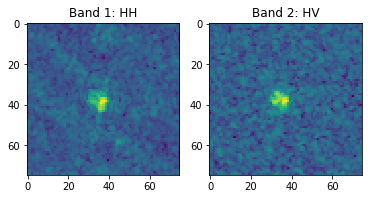

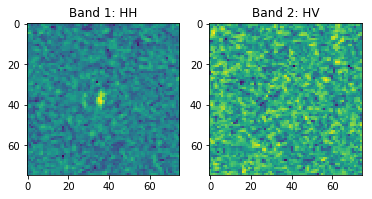

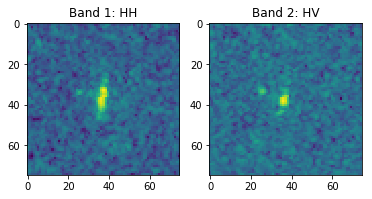

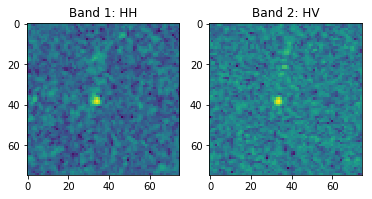

In [115]:
predicted_ships = train_data[pred_val <= 0.5]
misclassified_icebergs = predicted_ships[predicted_ships['is_iceberg'] == 1]
show_bands(misclassified_icebergs.iloc[19])
show_bands(misclassified_icebergs.iloc[20])
show_bands(misclassified_icebergs.iloc[21])
show_bands(misclassified_icebergs.iloc[25])

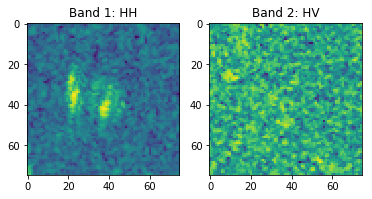

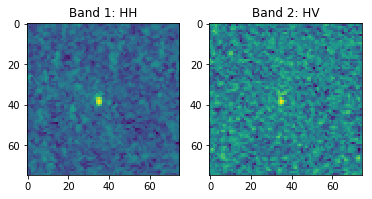

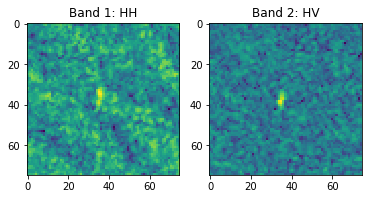

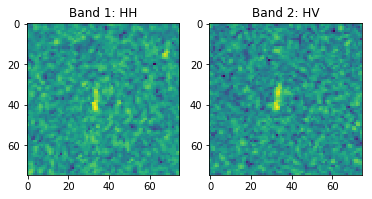

In [116]:
predicted_icebergs = train_data[pred_val > 0.5]
misclassified_ships = predicted_icebergs[predicted_icebergs['is_iceberg'] == 0]
show_bands(misclassified_ships.iloc[4])
show_bands(misclassified_ships.iloc[5])
show_bands(misclassified_ships.iloc[6])
show_bands(misclassified_ships.iloc[7])

*** Achieved test loss (on Kaggle platform): *** 0.3073

#### Model trained on the preprocessed images

In [3]:
# build model 1
from keras.layers import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.layers import Input, Dense
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.layers.normalization import BatchNormalization
import keras

In [16]:
epochs = 200
batch_size = 50

train_datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.6,
        height_shift_range=0.6,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='reflect')

valid_datagen = ImageDataGenerator()

earlyStopping = EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, epsilon=1e-4, mode='min')
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.with_transformed_data.hdf5', 
                               verbose=1, save_best_only=True)

model = naive_model()
history = model.fit_generator(train_datagen.flow(X_train_filt, y_train_lab, batch_size=batch_size),
                    steps_per_epoch=X_train_filt.shape[0] // batch_size,
                    epochs=epochs, verbose=1, callbacks=[checkpointer, earlyStopping, reduce_lr_loss],
                    validation_data=valid_datagen.flow(X_valid_filt, y_valid_lab, batch_size=batch_size),
                    validation_steps=X_valid_filt.shape[0] // batch_size)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 73, 73, 64)        1792      
_________________________________________________________________
activation_16 (Activation)   (None, 73, 73, 64)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
activation_17 (Activation)   (None, 34, 34, 128)       0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 17, 17, 128)       0         
__________

22/22 [==============================] - 21s - loss: 0.5111 - acc: 0.7536 - val_loss: 0.3717 - val_acc: 0.8270
Epoch 48/200
22/22 [==============================] - 18s - loss: 0.5126 - acc: 0.7723 - val_loss: 0.3511 - val_acc: 0.8491
Epoch 49/200
22/22 [==============================] - 20s - loss: 0.5107 - acc: 0.7650 - val_loss: 0.3747 - val_acc: 0.8257
Epoch 50/200
22/22 [==============================] - 22s - loss: 0.4901 - acc: 0.7841 - val_loss: 0.3564 - val_acc: 0.8396
Epoch 51/200
22/22 [==============================] - 20s - loss: 0.4861 - acc: 0.7632 - val_loss: 0.3774 - val_acc: 0.8522
Epoch 52/200
22/22 [==============================] - 19s - loss: 0.4934 - acc: 0.7359 - val_loss: 0.3653 - val_acc: 0.8302
Epoch 53/200
22/22 [==============================] - 17s - loss: 0.5353 - acc: 0.7359 - val_loss: 0.4171 - val_acc: 0.7799
Epoch 54/200
22/22 [==============================] - 21s - loss: 0.5157 - acc: 0.7550 - val_loss: 0.4256 - val_acc: 0.7736
Epoch 55/200
22/22 [=

22/22 [==============================] - 18s - loss: 0.4103 - acc: 0.8015 - val_loss: 0.3044 - val_acc: 0.8931
Epoch 79/200
22/22 [==============================] - 20s - loss: 0.3985 - acc: 0.8224 - val_loss: 0.3092 - val_acc: 0.8868
Epoch 80/200
22/22 [==============================] - 21s - loss: 0.4386 - acc: 0.7742 - val_loss: 0.3131 - val_acc: 0.8774
Epoch 81/200
22/22 [==============================] - 18s - loss: 0.4079 - acc: 0.8206 - val_loss: 0.3212 - val_acc: 0.8743
Epoch 82/200
22/22 [==============================] - 21s - loss: 0.4251 - acc: 0.8179 - val_loss: 0.3321 - val_acc: 0.8585
Epoch 83/200
22/22 [==============================] - 20s - loss: 0.4405 - acc: 0.7787 - val_loss: 0.3017 - val_acc: 0.8679
Epoch 84/200
22/22 [==============================] - 22s - loss: 0.4009 - acc: 0.8224 - val_loss: 0.2988 - val_acc: 0.8836
Epoch 85/200
22/22 [==============================] - 21s - loss: 0.3874 - acc: 0.8115 - val_loss: 0.3250 - val_acc: 0.8553
Epoch 86/200
22/22 [=

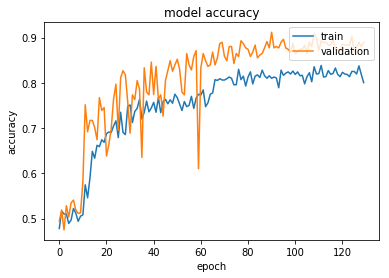

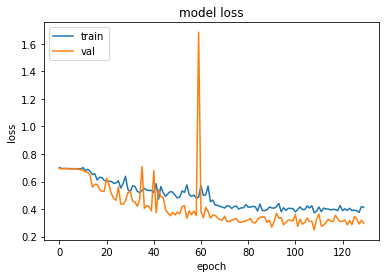

368/368 [==============================] - 1s     


In [17]:
# load best model
model.load_weights('saved_models/weights.best.from_scratch.with_transformed_data.hdf5')

# plot learning curves
plot_history(history)

#evaluate validation dataset
evl = model.evaluate(X_valid_filt, y_valid_lab)
# make test predictions
predictions = model.predict(test_images_filt)

# create file for submission
write_submission_file(test_data['id'], predictions.reshape((predictions.shape[0])), 'with_transformed_data', evl[0])

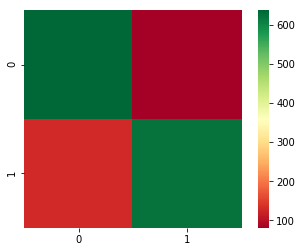

In [22]:
pred_val = model.predict(train_images)
pred_val = pred_val.reshape((pred_val.shape[0]))
plot_confusion_matrix(train_labels, pred_val > 0.5)

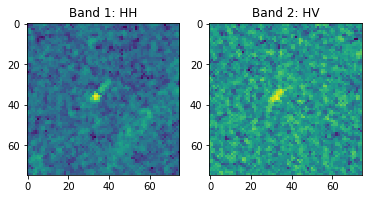

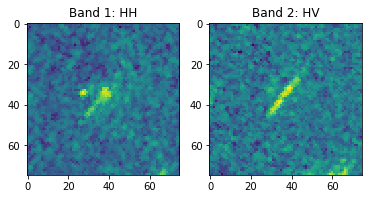

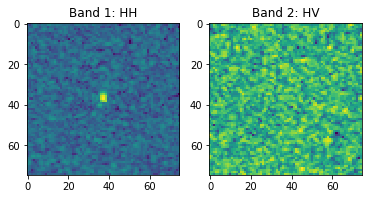

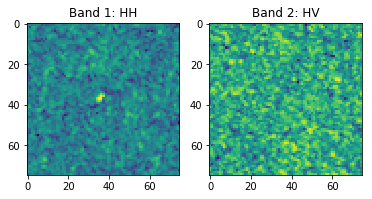

In [23]:
predicted_ships = train_data[pred_val <= 0.5]
misclassified_icebergs = predicted_ships[predicted_ships['is_iceberg'] == 1]
show_bands(misclassified_icebergs.iloc[19])
show_bands(misclassified_icebergs.iloc[20])
show_bands(misclassified_icebergs.iloc[21])
show_bands(misclassified_icebergs.iloc[25])

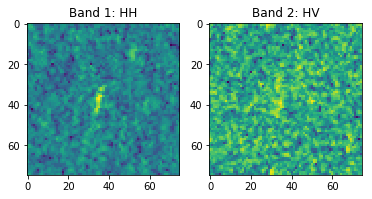

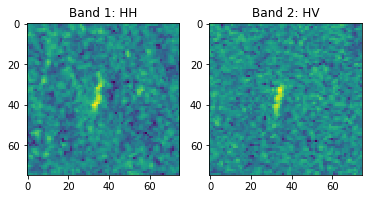

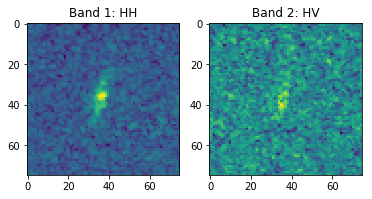

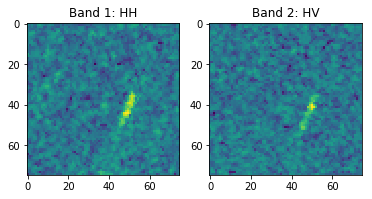

In [24]:
predicted_icebergs = train_data[pred_val > 0.5]
misclassified_ships = predicted_icebergs[predicted_icebergs['is_iceberg'] == 0]
show_bands(misclassified_ships.iloc[4])
show_bands(misclassified_ships.iloc[5])
show_bands(misclassified_ships.iloc[6])
show_bands(misclassified_ships.iloc[7])

*** Achieved test log loss (on Kaggle platform): *** 0.2947 

#### Model trained on extra dataset (normal data + filtered data with different smoothing levels)

In [65]:
epochs = 200
batch_size = 50

train_datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.6,
        height_shift_range=0.6,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='reflect')

valid_datagen = ImageDataGenerator()

earlyStopping = EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, epsilon=1e-4, mode='min')
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.extra.hdf5', 
                               verbose=1, save_best_only=True)

model = naive_model()
history = model.fit_generator(train_datagen.flow(X_train_extra, y_train_extra, batch_size=batch_size),
                    steps_per_epoch=X_train_extra.shape[0] // batch_size,
                    epochs=epochs, verbose=1, callbacks=[checkpointer, earlyStopping, reduce_lr_loss],
                    validation_data=valid_datagen.flow(X_valid_extra, y_valid_extra, batch_size=batch_size),
                    validation_steps=X_valid_extra.shape[0] // batch_size)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 73, 73, 64)        1792      
_________________________________________________________________
activation_21 (Activation)   (None, 73, 73, 64)        0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
activation_22 (Activation)   (None, 34, 34, 128)       0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 17, 17, 128)       0         
__________

66/66 [==============================] - 61s - loss: 0.3937 - acc: 0.8265 - val_loss: 0.3140 - val_acc: 0.8852
Epoch 52/200
66/66 [==============================] - 62s - loss: 0.4038 - acc: 0.8219 - val_loss: 0.3162 - val_acc: 0.8871
Epoch 53/200
66/66 [==============================] - 63s - loss: 0.3851 - acc: 0.8241 - val_loss: 0.3216 - val_acc: 0.8899
Epoch 54/200
66/66 [==============================] - 64s - loss: 0.3947 - acc: 0.8150 - val_loss: 0.3271 - val_acc: 0.8899
Epoch 55/200
66/66 [==============================] - 63s - loss: 0.3907 - acc: 0.8192 - val_loss: 0.3183 - val_acc: 0.8861
Epoch 56/200
66/66 [==============================] - 63s - loss: 0.3864 - acc: 0.8239 - val_loss: 0.3053 - val_acc: 0.9013
Epoch 57/200
66/66 [==============================] - 62s - loss: 0.3927 - acc: 0.8212 - val_loss: 0.3113 - val_acc: 0.8871
Epoch 58/200
66/66 [==============================] - 63s - loss: 0.3993 - acc: 0.8192 - val_loss: 0.3195 - val_acc: 0.8824
Epoch 59/200
66/66 [=

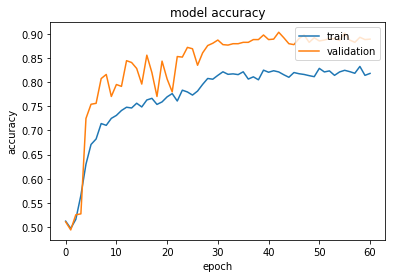

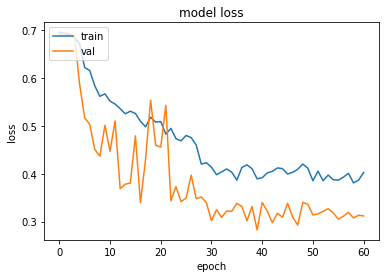

368/368 [==============================] - 1s     


In [66]:
# load best model
model.load_weights('saved_models/weights.best.from_scratch.extra.hdf5')

# plot learning curves
plot_history(history)

#evaluate validation dataset
evl = model.evaluate(X_valid_filt, y_valid_lab)
# make test predictions
predictions = model.predict(test_images_filt)

# create file for submission
write_submission_file(test_data['id'], predictions.reshape((predictions.shape[0])), 'extra', evl[0])

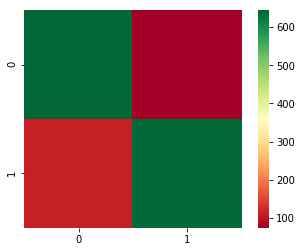

In [67]:
pred_val = model.predict(train_images)
pred_val = pred_val.reshape((pred_val.shape[0]))
plot_confusion_matrix(train_labels, pred_val > 0.5)

*** Test log loss (on Kaggle platform):*** 0.2821

#### Build model with a transferred weights

In [16]:
from keras import applications
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.layers import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.models import Sequential


def transfer_learning_model():
    base_model = applications.VGG16(include_top=False, weights='imagenet')

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.7)(x)
    x = Dense(150, activation='relu')(x)
    x = Dropout(0.7)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)    
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = transfer_learning_model()

In [69]:
train_datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.5,
        height_shift_range=0.5,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')


valid_datagen = ImageDataGenerator()

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.transfered.hdf5', 
                               verbose=1, save_best_only=True)

epochs = 25
batch_size = 50
model.fit_generator(train_datagen.flow(X_train, y_train_lab, batch_size=batch_size),
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    epochs=epochs, verbose=1, callbacks=[checkpointer],
                    validation_data=valid_datagen.flow(X_valid, y_valid_lab, batch_size=batch_size),
                    validation_steps=X_valid.shape[0] // batch_size)

Epoch 1/25
22/22 [==============================] - 70s - loss: 0.7791 - acc: 0.5509 - val_loss: 0.6407 - val_acc: 0.7571
Epoch 2/25
22/22 [==============================] - 75s - loss: 0.7249 - acc: 0.5346 - val_loss: 0.6374 - val_acc: 0.6950
Epoch 3/25
22/22 [==============================] - 73s - loss: 0.6865 - acc: 0.5692 - val_loss: 0.6129 - val_acc: 0.7264
Epoch 4/25
22/22 [==============================] - 74s - loss: 0.6811 - acc: 0.5665 - val_loss: 0.5909 - val_acc: 0.7075
Epoch 5/25
22/22 [==============================] - 76s - loss: 0.6585 - acc: 0.6011 - val_loss: 0.5804 - val_acc: 0.7767
Epoch 6/25
22/22 [==============================] - 77s - loss: 0.6635 - acc: 0.5956 - val_loss: 0.6092 - val_acc: 0.6415
Epoch 7/25
22/22 [==============================] - 77s - loss: 0.6385 - acc: 0.6275 - val_loss: 0.5688 - val_acc: 0.6981
Epoch 8/25
22/22 [==============================] - 81s - loss: 0.6181 - acc: 0.6739 - val_loss: 0.5759 - val_acc: 0.6667
Epoch 9/25
22/22 [======

In [19]:
from keras.optimizers import SGD

train_datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.5,
        height_shift_range=0.5,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')


valid_datagen = ImageDataGenerator()


model.load_weights('saved_models/weights.best.from_scratch.transfered.hdf5')
for layer in model.layers:
    layer.trainable = True
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.transfered_upd.hdf5', 
                               verbose=1, save_best_only=True)

epochs = 200
batch_size = 50
history = model.fit_generator(train_datagen.flow(X_train_extra, y_train_extra, batch_size=batch_size),
                    steps_per_epoch=X_train_extra.shape[0] // batch_size,
                    epochs=epochs, verbose=1, callbacks=[checkpointer],
                    validation_data=valid_datagen.flow(X_valid_extra, y_valid_extra, batch_size=batch_size),
                    validation_steps=X_valid_extra.shape[0] // batch_size)

Epoch 1/200
72/72 [==============================] - 687s - loss: 0.5932 - acc: 0.6775 - val_loss: 0.4562 - val_acc: 0.7817
Epoch 2/200
72/72 [==============================] - 675s - loss: 0.5397 - acc: 0.7195 - val_loss: 0.4049 - val_acc: 0.8196
Epoch 3/200
72/72 [==============================] - 681s - loss: 0.5216 - acc: 0.7407 - val_loss: 0.3792 - val_acc: 0.8369
Epoch 4/200
72/72 [==============================] - 680s - loss: 0.5034 - acc: 0.7470 - val_loss: 0.3666 - val_acc: 0.8378
Epoch 5/200
72/72 [==============================] - 693s - loss: 0.4908 - acc: 0.7544 - val_loss: 0.3294 - val_acc: 0.8578
Epoch 6/200
72/72 [==============================] - 687s - loss: 0.4911 - acc: 0.7557 - val_loss: 0.3329 - val_acc: 0.8474
Epoch 7/200
72/72 [==============================] - 753s - loss: 0.4666 - acc: 0.7727 - val_loss: 0.3307 - val_acc: 0.8413
Epoch 8/200
72/72 [==============================] - 688s - loss: 0.4504 - acc: 0.7786 - val_loss: 0.3292 - val_acc: 0.8474
Epoch 9/

72/72 [==============================] - 672s - loss: 0.3311 - acc: 0.8390 - val_loss: 0.2351 - val_acc: 0.8985
Epoch 63/200
72/72 [==============================] - 669s - loss: 0.3417 - acc: 0.8340 - val_loss: 0.2380 - val_acc: 0.8959
Epoch 64/200
72/72 [==============================] - 669s - loss: 0.3245 - acc: 0.8508 - val_loss: 0.2312 - val_acc: 0.8864
Epoch 65/200
72/72 [==============================] - 668s - loss: 0.3274 - acc: 0.8441 - val_loss: 0.2380 - val_acc: 0.8846
Epoch 66/200
72/72 [==============================] - 675s - loss: 0.3272 - acc: 0.8444 - val_loss: 0.2395 - val_acc: 0.8855
Epoch 67/200
72/72 [==============================] - 672s - loss: 0.3376 - acc: 0.8448 - val_loss: 0.2189 - val_acc: 0.9081
Epoch 68/200
72/72 [==============================] - 682s - loss: 0.3326 - acc: 0.8433 - val_loss: 0.2229 - val_acc: 0.9133
Epoch 69/200
72/72 [==============================] - 671s - loss: 0.3117 - acc: 0.8569 - val_loss: 0.2715 - val_acc: 0.8647
Epoch 70/200


72/72 [==============================] - 695s - loss: 0.3000 - acc: 0.8639 - val_loss: 0.2037 - val_acc: 0.9063
Epoch 128/200
72/72 [==============================] - 686s - loss: 0.2997 - acc: 0.8541 - val_loss: 0.2353 - val_acc: 0.9072
Epoch 129/200
72/72 [==============================] - 682s - loss: 0.3079 - acc: 0.8562 - val_loss: 0.2049 - val_acc: 0.9159
Epoch 130/200
72/72 [==============================] - 694s - loss: 0.3126 - acc: 0.8568 - val_loss: 0.1982 - val_acc: 0.9167
Epoch 131/200
72/72 [==============================] - 688s - loss: 0.2930 - acc: 0.8614 - val_loss: 0.2200 - val_acc: 0.9124
Epoch 132/200
72/72 [==============================] - 696s - loss: 0.2911 - acc: 0.8629 - val_loss: 0.2240 - val_acc: 0.9020
Epoch 133/200
72/72 [==============================] - 692s - loss: 0.2960 - acc: 0.8730 - val_loss: 0.2115 - val_acc: 0.8994
Epoch 134/200
72/72 [==============================] - 693s - loss: 0.3038 - acc: 0.8561 - val_loss: 0.2250 - val_acc: 0.8933
Epoch 

72/72 [==============================] - 674s - loss: 0.2661 - acc: 0.8808 - val_loss: 0.1895 - val_acc: 0.9185
Epoch 195/200
72/72 [==============================] - 672s - loss: 0.2757 - acc: 0.8808 - val_loss: 0.2025 - val_acc: 0.9089
Epoch 196/200
72/72 [==============================] - 679s - loss: 0.2966 - acc: 0.8566 - val_loss: 0.1905 - val_acc: 0.9107
Epoch 197/200
72/72 [==============================] - 673s - loss: 0.2887 - acc: 0.8698 - val_loss: 0.2291 - val_acc: 0.9011
Epoch 198/200
72/72 [==============================] - 670s - loss: 0.2766 - acc: 0.8693 - val_loss: 0.1921 - val_acc: 0.9133
Epoch 199/200
72/72 [==============================] - 673s - loss: 0.2785 - acc: 0.8694 - val_loss: 0.1854 - val_acc: 0.9202
Epoch 200/200
72/72 [==============================] - 678s - loss: 0.2831 - acc: 0.8661 - val_loss: 0.1969 - val_acc: 0.9115


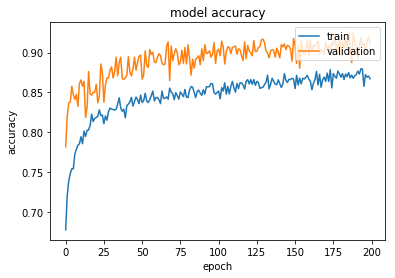

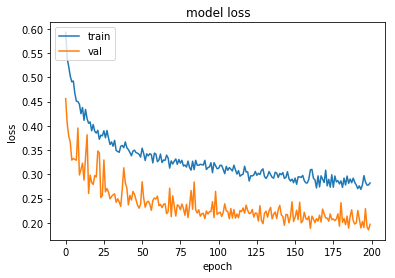

1203/1203 [==============================] - 60s    


In [21]:
# load best model
model.load_weights('saved_models/weights.best.from_scratch.transfered_upd.hdf5')

# plot learning curves
plot_history(history)

#evaluate validation dataset
evl = model.evaluate(X_valid_extra, y_valid_extra)
# make test predictions
predictions = model.predict(test_images)

# create file for submission
write_submission_file(test_data['id'], predictions.reshape((predictions.shape[0])), 'transfered', evl[0])

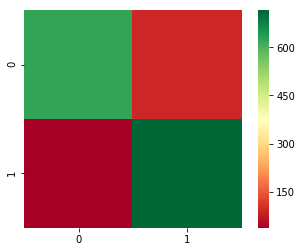

In [17]:
model.load_weights('saved_models/weights.best.from_scratch.transfered_upd.hdf5')

pred_val = model.predict(train_images)
pred_val = pred_val.reshape((pred_val.shape[0]))
plot_confusion_matrix(train_labels, pred_val > 0.5)

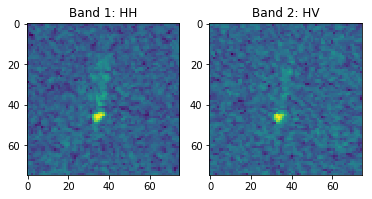

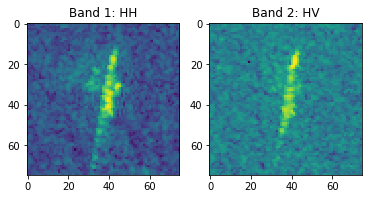

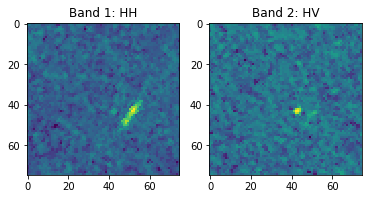

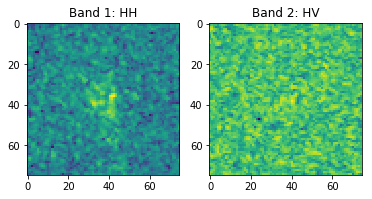

In [19]:
predicted_ships = train_data[pred_val <= 0.5]
misclassified_icebergs = predicted_ships[predicted_ships['is_iceberg'] == 1]
show_bands(misclassified_icebergs.iloc[19])
show_bands(misclassified_icebergs.iloc[20])
show_bands(misclassified_icebergs.iloc[21])
show_bands(misclassified_icebergs.iloc[25])

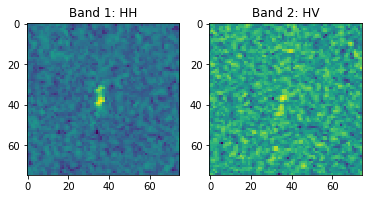

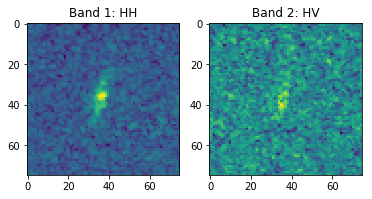

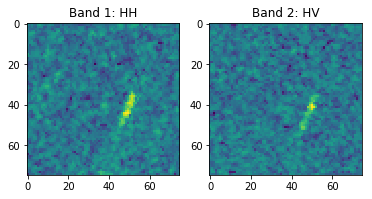

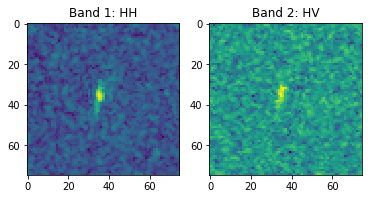

In [20]:
predicted_icebergs = train_data[pred_val > 0.5]
misclassified_ships = predicted_icebergs[predicted_icebergs['is_iceberg'] == 0]
show_bands(misclassified_ships.iloc[4])
show_bands(misclassified_ships.iloc[5])
show_bands(misclassified_ships.iloc[6])
show_bands(misclassified_ships.iloc[7])

** Test log loss (on the Kaggle plarform): ** 0.2275